In [2]:
# Import necessary packages

import sf_quant.data as sfd
import polars as pl
import polars_ols as pls  
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
# Date range
start = dt.date(1995, 6, 30)
end = dt.date(2024, 12, 31)

In [4]:
barrid_sector = pl.read_parquet(r"C:\Users\J\Documents\Code\sf_database\barrid_primary_sector.parquet")

assets = sfd.load_assets(
    start=start, 
    end=end, 
    in_universe=True, 
    columns=["date", "barrid", "return", "daily_volume", "price", "specific_risk"]
)

In [5]:
data = barrid_sector.join(assets, on=["date", "barrid"]).select(
    "date", "barrid", "return", "daily_volume", "price", "specific_risk", pl.col("primary_sector").alias("sector")
)

In [12]:
# 22D Rolling Dollar-volume Autocorrelation
AUTOCORR_WINDOW = 22

signal_df = (
    data
    .with_columns(pl.col("return").truediv(100))
    # Calculate dollar volume
    .with_columns(pl.col("price").mul(pl.col("daily_volume")).alias("dollar_volume"))
    .sort("barrid", "date")
    # Lag-1 dollar volume
    .with_columns(pl.col("dollar_volume").shift(1).over("barrid").alias("dollar_volume_lag1"))
    # Calculate auto corr of dollar volume
    .with_columns(
        pl.rolling_corr(
            pl.col("dollar_volume"),
            pl.col("dollar_volume_lag1"),
            window_size=AUTOCORR_WINDOW
        ).alias("auto_corr")
    )
    # Demean auto-correlation within sector (per date)
    .with_columns(
        pl.col("auto_corr").sub(pl.col("auto_corr").mean().over("date", "sector")).alias("auto_corr_demeaned")
    )
    # Z-score of autocorr within sector (mean reversion within sector)
    .with_columns(
        (pl.col("auto_corr_demeaned") / pl.col("auto_corr_demeaned").std().over("date", "sector")).alias("auto_corr_zscore")
    )
    # Multiply by -1 and shift to get signal
    .with_columns(
        (-pl.col("auto_corr_zscore")).alias("signal")
    )
    .with_columns(pl.col("signal").shift(2).over("barrid").alias("signal_lag"))
    .filter(pl.col("signal_lag").is_not_null())
)

signal_df 

date,barrid,return,daily_volume,price,specific_risk,sector,dollar_volume,dollar_volume_lag1,auto_corr,auto_corr_demeaned,auto_corr_zscore,signal,signal_lag
date,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
2013-09-04,"""USA06Z1""",-0.364686,1.485603e6,3.85,60.857143,"""USSLOWL_BIOLIFE""",5.7196e6,356309.82,-0.006896,-0.242382,-1.083656,1.083656,0.163194
2013-09-05,"""USA06Z1""",0.197403,489416.0,4.61,56.126786,"""USSLOWL_BIOLIFE""",2.2562e6,5.7196e6,0.241455,0.001288,0.005586,-0.005586,0.193475
2013-09-06,"""USA06Z1""",-0.088937,249452.0,4.2,57.223959,"""USSLOWL_BIOLIFE""",1047698.4,2.2562e6,0.23895,0.003376,0.015293,-0.015293,1.083656
2013-09-09,"""USA06Z1""",-0.035714,130867.0,4.05,58.228041,"""USSLOWL_BIOLIFE""",530011.35,1047698.4,0.233645,0.000765,0.00316,-0.00316,-0.005586
2013-09-10,"""USA06Z1""",-0.02963,184016.0,3.93,58.633255,"""USSLOWL_BIOLIFE""",723182.88,530011.35,0.232293,0.004891,0.020445,-0.020445,-0.015293
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-24,"""USBQLU1""",0.021524,91407.0,23.73,24.73015,"""USSLOWL_REALEST""",2.1691e6,6.2453e6,0.323077,0.250921,1.869984,-1.869984,-1.874412
2024-12-26,"""USBQLU1""",0.006321,87363.0,23.88,26.07426,"""USSLOWL_REALEST""",2.0862e6,2.1691e6,0.330833,0.239734,1.749478,-1.749478,-1.790163
2024-12-27,"""USBQLU1""",-0.016332,142763.0,23.49,23.107239,"""USSLOWL_REALEST""",3.3535e6,2.0862e6,0.358754,0.246593,1.856252,-1.856252,-1.869984


In [ ]:
N_BINS = 5
BIN_LABELS = [str(i) for i in range(N_BINS)]  # 0=lowest signal, 4=highest signal

# Bin by signal cross-sectionally
rank_per_date = pl.col("signal_lag").rank("average").over("date")
count_per_date = pl.col("signal_lag").count().over("date")
bin_idx = (rank_per_date / count_per_date * N_BINS).floor().clip(0, N_BINS - 1).cast(pl.Int64)
signal_bins = signal_df.with_columns(bin_idx.cast(pl.Utf8).alias("bin"))

# Equal weight portfolio return per date per bin
portfolios_wide = (
    signal_bins
    .group_by("date", "bin")
    .agg(pl.col("return").mean())
    .sort("bin")
    .pivot(index="date", on="bin", values="return")
    .sort("date")
)
top_bin = BIN_LABELS[4]
bot_bin = BIN_LABELS[0]
portfolios_wide = portfolios_wide.with_columns(
    pl.col(top_bin).sub(pl.col(bot_bin)).alias("spread")
)

# Cumulative log return by bin
portfolio_returns_long = (
    portfolios_wide
    .unpivot(index="date", variable_name="bin", value_name="return")
    .with_columns(
        pl.col("return").log1p().cum_sum().over("bin").alias("cumulative_log_return")
    )
    .sort("bin", "date")
    .sort("bin", "date")
)

# Performance table: annualized mean return, vol, sharpe
daily_ret = portfolio_returns_long.filter(pl.col("return").is_not_null())
performance = (
    daily_ret
    .group_by("bin")
    .agg(
        pl.col("return").mean().mul(252).alias("average_return"),
        pl.col("return").std().mul(pl.lit(252).sqrt()).alias("volatility"),
    )
    .with_columns(pl.col("average_return").truediv(pl.col("volatility")).alias("sharpe"))
    .sort("bin")
)
performance

bin,average_return,volatility,sharpe
str,f64,f64,f64
"""0""",0.121537,0.237406,0.511937
"""1""",0.129041,0.233883,0.551734
"""2""",0.132736,0.23279,0.570198
"""3""",0.126635,0.232644,0.544331
"""4""",0.121999,0.231822,0.526262
"""spread""",0.000462,0.048039,0.009623


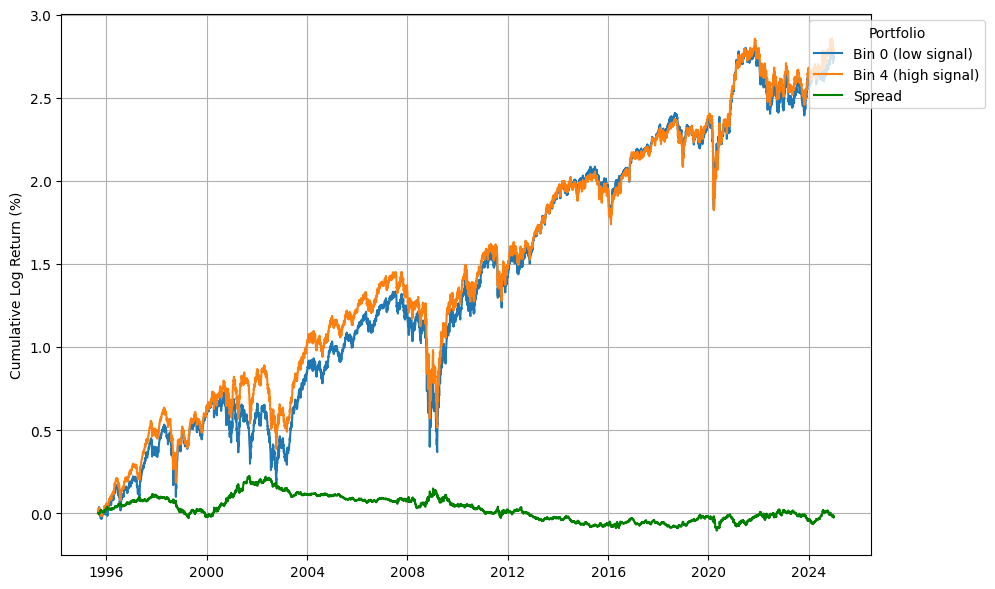

In [ ]:
# Chart cumulative log returns
portfolio_returns_wide = (
    portfolio_returns_long
    .sort("bin")
    .pivot(index="date", on="bin", values="cumulative_log_return")
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(portfolio_returns_wide["date"], portfolio_returns_wide[bot_bin], label=f"Bin {bot_bin} (low signal)")
ax.plot(portfolio_returns_wide["date"], portfolio_returns_wide[top_bin], label=f"Bin {top_bin} (high signal)")
ax.plot(portfolio_returns_wide["date"], portfolio_returns_wide["spread"], color="green", label="Spread")
ax.set_ylabel("Cumulative Log Return (%)")
ax.legend(title="Portfolio", bbox_to_anchor=(1.15, 1), loc="upper right")
ax.grid(True)
plt.tight_layout()
plt.show()